<a href="https://colab.research.google.com/github/charu210703/ML-Lab-assignments/blob/main/a6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import KNeighborsClassifier
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [3]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [4]:
train_set['index'] = train_set.index
test_set['index'] = test_set.index

In [5]:
print("Train set shape: ",train_set.shape)
print("Test set shape: ",test_set.shape)

In [6]:
print("train set:",train_set.isnull().values.any())
print("test set:",test_set.isnull().values.any())

train set: False
test set: False


# Data Visualization

In [7]:
train_set["Activity"].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

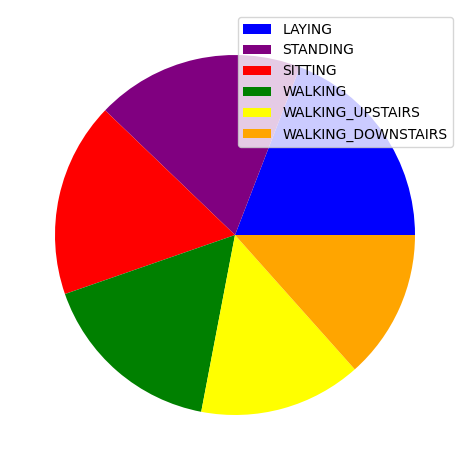

In [8]:
activities = train_set["Activity"].value_counts()
labels = activities.index
values = activities.values

colors = ['blue','purple', 'red', 'green','yellow', 'orange']
patches, texts = plt.pie(values, colors=colors)
plt.legend(patches, labels)
plt.tight_layout()
plt.show()

# K-Means

In [11]:
y_train = train_set["Activity"]
X_train = train_set.drop(["Activity","subject"], axis=1)

y_test = test_set["Activity"]
X_test = test_set.drop(["Activity","subject"], axis=1)

In [23]:
print("Column Names:", X_train.columns)
print("First few rows of X_train:")
print(X_train.head())

Column Names: Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'index'],
      dtype='object', length=562)
First few rows of X_train:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.200642          -0.063683          -0.419628         -0.868814   
1           0.055948           0.031486          -0.253908         -0.875426   
2           0.073515          -0.043416          -0.076295         -0.869039   
3           0.066696         

In [12]:
scaler = StandardScaler()
for col in X_train.columns:
    X_train[col]  = scaler.fit_transform(X_train[[col]])
for col in X_test.columns:
    X_test[col]  = scaler.fit_transform(X_test[[col]])

## Find k using elbow method

In [13]:
inertia = []
#consider 8 clusters
for nr in range(1 , 9):
    model = (KMeans(n_clusters = nr, random_state= 111  , algorithm='elkan') )
    model.fit(X_train)
    inertia.append(model.inertia_)

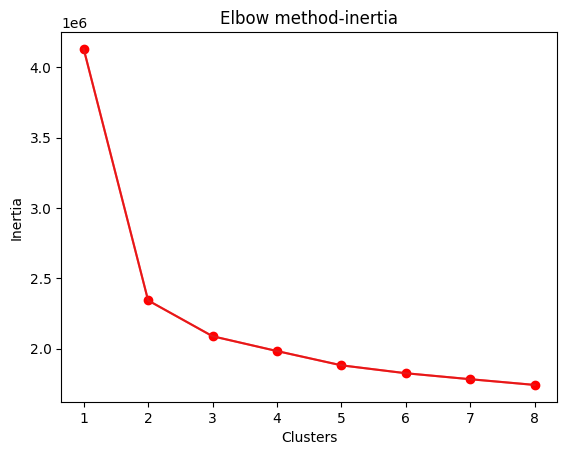

In [14]:
plt.plot(np.arange(1 ,9) , inertia , 'ro-')
plt.plot(np.arange(1 , 9) , inertia , alpha = 0.5)
plt.xlabel('Clusters') , plt.ylabel('Inertia')
plt.title("Elbow method-inertia")
plt.show()

## k = 2 (obtained from elbow method)

In [15]:
km2 = KMeans(n_clusters=2,algorithm="elkan",random_state=111).fit(X_train)

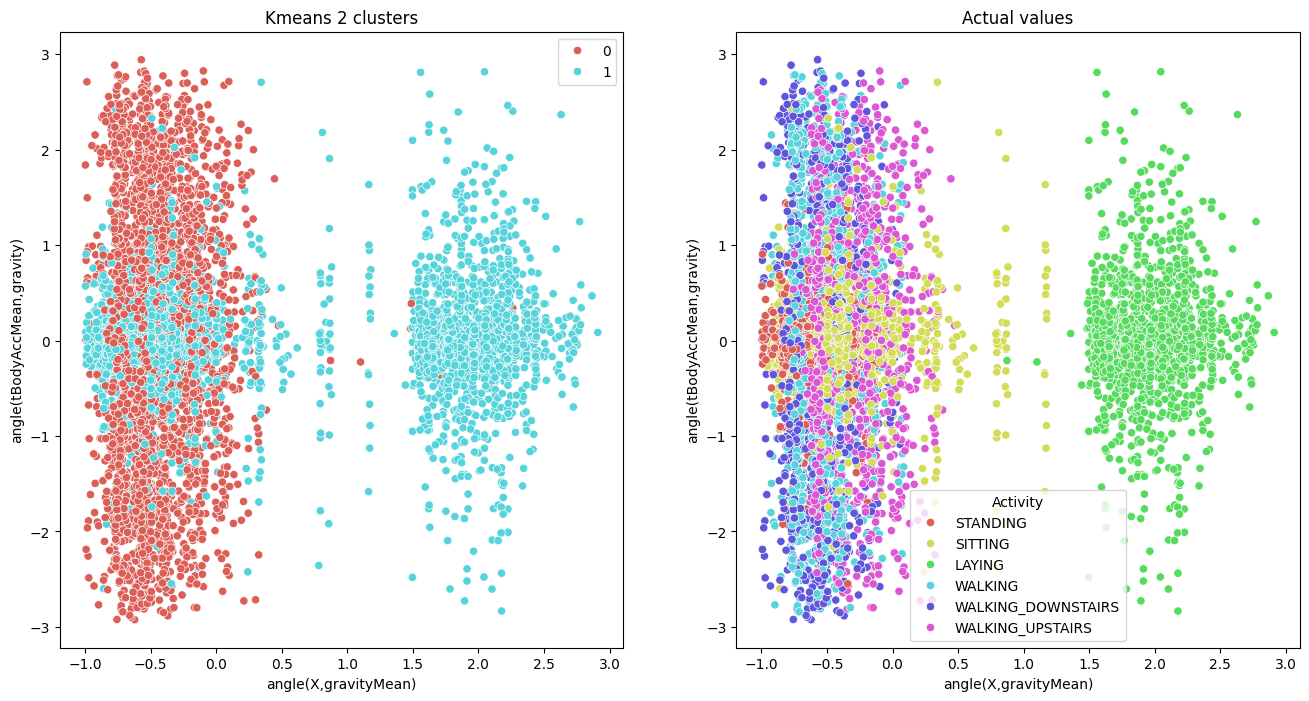

In [18]:

y_pred_2 = km2.labels_

f, axes = plt.subplots(1, 2)
f.set_figheight(8)
f.set_figwidth(16)

sns.scatterplot(x=X_train["angle(X,gravityMean)"], y=X_train["angle(tBodyAccMean,gravity)"], hue=y_pred_2,
                palette=sns.color_palette('hls', 2), ax=axes[0]).set_title("Kmeans 2 clusters")

sns.scatterplot(x=X_train["angle(X,gravityMean)"], y=X_train["angle(tBodyAccMean,gravity)"], hue=y_train,
                palette=sns.color_palette('hls', 6), ax=axes[1]).set_title("Actual values")

plt.show()


### Accracy

In [19]:
def two_labels(dataset):
    dataset_copied = dataset.copy()
    for label in range(len(dataset)):
        if dataset[label] == "SITTING":
            dataset[label] = 0
        elif dataset[label] == "LAYING":
            dataset[label] = 0
        elif dataset[label] == "STANDING":
            dataset[label] = 0
        elif dataset[label] == "WALKING_UPSTAIRS":
            dataset[label] = 1
        elif dataset[label] == "WALKING_DOWNSTAIRS":
            dataset[label] = 1
        elif dataset[label] == "WALKING":
            dataset[label] = 1
    return dataset_copied, dataset
y_train, y_train_2 = two_labels(y_train)
y_test, y_test_2 = two_labels(y_test)

In [20]:
conf_matrix = np.zeros((2,2))
for train_label, pred_label in zip(y_train_2.values, y_pred_2):
    conf_matrix[train_label][pred_label] +=1

row_ind, col_ind = linear_sum_assignment(1/conf_matrix)

interpret = dict(zip(col_ind, row_ind))
predicted_labels = np.array([interpret[label]
                            for label in y_pred_2])
print("Accuracy",np.mean(predicted_labels == y_train_2))

Accuracy 0.9972796517954298


## K means user defined with euclidean distance metric

In [34]:
class KMeans:
    def __init__(self, n_clusters, max_iters=300):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        self.labels_ = self._assign_clusters(X)

    def _assign_clusters(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros_like(self.centroids)
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                new_centroids[i] = self.centroids[i]
        return new_centroids

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train[['angle(X,gravityMean)', 'angle(tBodyAccMean,gravity)']].values)
y_pred_2 = kmeans.labels_



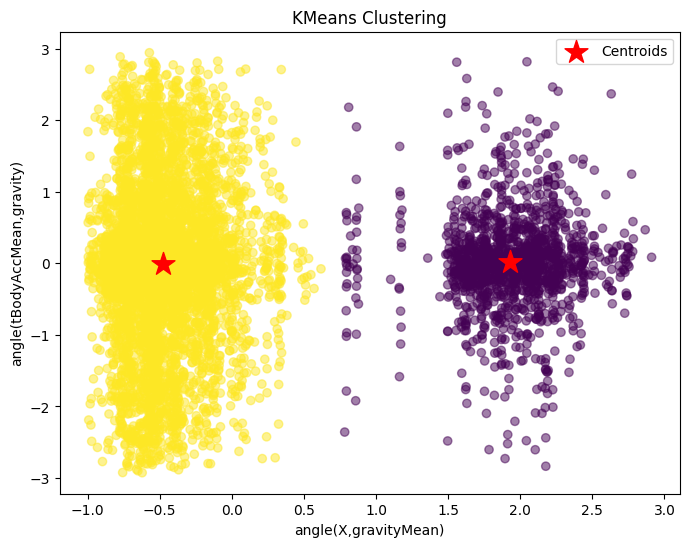

In [38]:
import matplotlib.pyplot as plt

X = X_train[['angle(X,gravityMean)', 'angle(tBodyAccMean,gravity)']].values

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

centroids = kmeans.centroids
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='red', s=300, label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('angle(X,gravityMean)')
plt.ylabel('angle(tBodyAccMean,gravity)')
plt.legend()
plt.show()


### Accuracy

In [35]:
def two_labels(dataset):
    dataset_copied = dataset.copy()
    for label in range(len(dataset)):
        if dataset[label] == "SITTING":
            dataset[label] = 0
        elif dataset[label] == "LAYING":
            dataset[label] = 0
        elif dataset[label] == "STANDING":
            dataset[label] = 0
        elif dataset[label] == "WALKING_UPSTAIRS":
            dataset[label] = 1
        elif dataset[label] == "WALKING_DOWNSTAIRS":
            dataset[label] = 1
        elif dataset[label] == "WALKING":
            dataset[label] = 1
    return dataset_copied, dataset
y_train, y_train_2 = two_labels(y_train)
y_test, y_test_2 = two_labels(y_test)

In [36]:
epsilon = 1e-9  # Small epsilon value to avoid division by zero

conf_matrix += epsilon * np.eye(conf_matrix.shape[0])
cost_matrix = 1 / conf_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)
interpret = dict(zip(col_ind, row_ind))
predicted_labels = np.array([interpret[label] for label in y_pred_2])

accuracy = np.mean(predicted_labels == y_train_2)
print("Accuracy:", accuracy)


Accuracy: 0.6451305767138193
